In [1]:
%matplotlib inline

# Geometric Median Composites for Landsat 7 Imagery  
  
This notebook is inspired by an IEEE publication titled [High-Dimensional Pixel Composites From
Earth Observation Time Series](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8004469) authored by Dale Roberts, Norman Mueller, and Alexis McIntyre.  
  
This notebook applies this compositing method to Landsat 7 imagery, displays a rendering of the computed composites, and saves them off to disk for further validation.  


# Loading the data  

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [2]:
import datacube
dc = datacube.Datacube()

> **Listing available products**  
> Lookup product/platform name to load in your data.
<br>  

In [3]:
product_listing = dc.list_products()
product_listing[product_listing["name"].str.contains('vietnam')]

,name,description,label,platform,lat,creation_time,product_type,instrument,format,lon,time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
31,ls7_ledaps_vietnam,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,LANDSAT_7,None,None,LEDAPS,ETM,NetCDF,None,None,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"


In [4]:
platform = 'LANDSAT_7'
product = 'ls7_ledaps_vietnam'

> **Select and visualize**  
> Select and visualize the region you'll be working with.  
<br>  

In [5]:
lat = (11.1285, 11.2072)
lon = (107.2200, 107.3241)

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat,longitude = lon)  

### Narrow down time range

In [7]:
from datetime import datetime 

date_range = ( datetime(2015,1,1), datetime(2015,12,24))

### Load product

In [8]:

landsat_dataset = dc.load(product = product,\
	platform = platform,\
	lat = lat,\
	lon = lon,\
	time = date_range,\
	measurements = ['red','green','nir','swir1', 'swir2','blue', 'pixel_qa'])


In [9]:
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 292, longitude: 388, time: 18)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-09T03:06:13 ... 2015-12-11T03:08:46
  * latitude   (latitude) float64 11.21 11.21 11.21 11.21 ... 11.13 11.13 11.13
  * longitude  (longitude) float64 107.2 107.2 107.2 107.2 ... 107.3 107.3 107.3
Data variables:
    red        (time, latitude, longitude) int16 856 775 776 ... -9999 -9999
    green      (time, latitude, longitude) int16 895 960 917 ... -9999 -9999
    nir        (time, latitude, longitude) int16 1084 1130 1130 ... -9999 -9999
    swir1      (time, latitude, longitude) int16 582 608 582 ... -9999 -9999
    swir2      (time, latitude, longitude) int16 487 515 487 ... -9999 -9999
    blue       (time, latitude, longitude) int16 932 890 890 ... -9999 -9999
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 224 ... 1 1 1 1
Attributes:
    crs:      EPSG:4326

# Create a cloud mask  

In [10]:
from functools import reduce  
import numpy as np  

def ls7_qa_mask(dataset, keys):
    land_cover_endcoding = dict( fill     =  [1], 
                                 clear    =  [66,  130], 
                                 water    =  [68,  132],
                                 shadow   =  [72,  136],
                                 snow     =  [80,  112, 144, 176],
                                 cloud    =  [96,  112, 160, 176, 224],
                                 low_conf =  [66,  68,  72,  80,  96,  112],
                                 med_conf =  [130, 132, 136, 144, 160, 176],
                                 high_conf=  [224]
                               ) 
    def merge_lists(a, b): 
        return a.union(set(land_cover_endcoding[b]))
                        
    relevant_encodings = reduce(merge_lists, keys,set())
    return np.isin(dataset.pixel_qa.values, list(relevant_encodings)) 


In [11]:
clean_mask_np = ls7_qa_mask(landsat_dataset, ["clear", "water"])

# Geometric Median/Medoid Compositing

In [12]:
import hdmedians as hd
import xarray as xr  

def nan_to_num(dataset, number):
    for key in list(dataset.data_vars):
        dataset[key].values[np.isnan(dataset[key].values)] = number  
        
def create_hdmedians_multiple_band_mosaic(dataset_in,
                                          clean_mask=None,
                                          no_data=-9999,
                                          intermediate_product=None,
                                          operation="median",
                                          **kwargs):
        
    assert clean_mask is not None, "A boolean mask for clean_mask must be supplied."
    assert operation in ['median', 'medoid'], "Only median and medoid operations are supported."

    dataset_in_filtered = dataset_in.where((dataset_in != no_data) & (clean_mask))

    band_list = list(dataset_in_filtered.data_vars)
    arrays = [dataset_in_filtered[band] for band in band_list]

    stacked_data = np.stack(arrays)
    bands_shape, time_slices_shape, lat_shape, lon_shape = stacked_data.shape[0], stacked_data.shape[
        1], stacked_data.shape[2], stacked_data.shape[3]

    reshaped_stack = stacked_data.reshape(bands_shape, time_slices_shape,
                                          lat_shape * lon_shape)  # Reshape to remove lat/lon
    hdmedians_result = np.zeros((bands_shape, lat_shape * lon_shape))  # Build zeroes array across time slices.

    for x in range(reshaped_stack.shape[2]):
        try:
            hdmedians_result[:, x] = hd.nangeomedian(
                reshaped_stack[:, :, x], axis=1) if operation == "median" else hd.nanmedoid(
                    reshaped_stack[:, :, x], axis=1)
        except ValueError:
            no_data_pixel_stack = reshaped_stack[:, :, x]
            no_data_pixel_stack[np.isnan(no_data_pixel_stack)] = no_data
            hdmedians_result[:, x] = np.full((bands_shape), no_data) if operation == "median" else hd.nanmedoid(
                no_data_pixel_stack, axis=1)

    output_dict = {
        value: (('latitude', 'longitude'), hdmedians_result[index, :].reshape(lat_shape, lon_shape))
        for index, value in enumerate(band_list)
    }

    dataset_out = xr.Dataset(output_dict,
                             coords={'latitude': dataset_in['latitude'], 'longitude': dataset_in['longitude']},
                             attrs = dataset_in.attrs)
    nan_to_num(dataset_out, no_data)
    return dataset_out

----   

# Medoid   

> ### Geometric  Medoid Compositing   
> To compute a Geo-Medoid composite , the geometric medoid algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric medoid.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Medoid  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{x_1,...,x_n \}$ , the medoid  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ m := argmin_{ x \in \mathbb{X}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  


### Run Medoid compositor    

In [13]:
# from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
medoid_mosaic = create_hdmedians_multiple_band_mosaic( landsat_dataset,
                                                       clean_mask = clean_mask_np,
                                                       operation = 'medoid')

> ### Example of a composited `swir1` band

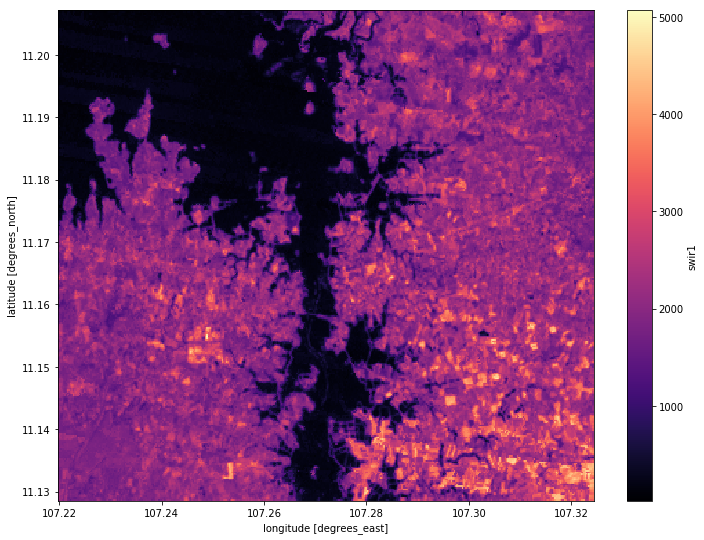

In [14]:
from utils.data_cube_utilities.plotter_utils import figure_ratio
figsize = figure_ratio(landsat_dataset, fixed_width=12)
medoid_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')

----  

# Median   

> ### Geometric  Median Compositing   
> To compute a Geo-Median composite , the geometric Median algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric Median.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Median  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{ x_1,...,x_n \}$ , the Median  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ \hat{\mu} := argmin_{ x \in \mathbb{R^{_p}}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  
> **Note:**  
> there is a subtle difference between the definition of the geometric median and the medoid: the search space for the solution differs and has the effect that the medoid returns one of the true observations whereas the geometric median can be described as a synthetic (not physically observed) observation.<sup>[[1]](#hd_medians)</sup> 


In [15]:
median_mosaic = create_hdmedians_multiple_band_mosaic(landsat_dataset,
                                               clean_mask = clean_mask_np,
                                               operation = 'median')

> ### Example of a composited `swir1` band

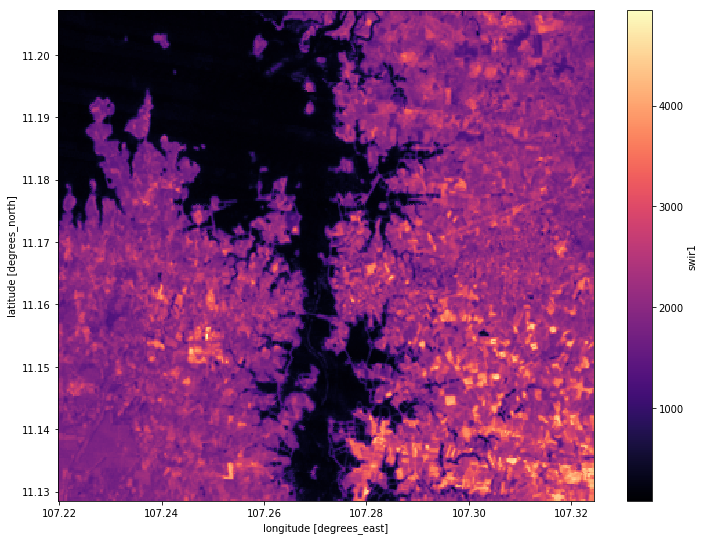

In [16]:
figsize = figure_ratio(landsat_dataset, fixed_width=12)
median_mosaic.swir1.plot(figsize = figsize, cmap = 'magma')

# Write both composites to file   
You may want to explore these files in with QGIS

>### PNG  

In [17]:
import os
png_dir = 'output/pngs'
if not os.path.exists(png_dir):
    os.makedirs(png_dir)
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
write_png_from_xr('{}/geo_median.png'.format(png_dir), median_mosaic, ['red','green','blue'], scale=(0,4000))
write_png_from_xr('{}/geo_medoid.png'.format(png_dir), medoid_mosaic, ['red','green','blue'], scale=(0,4000))

>### NetCDF

In [18]:
from utils.data_cube_utilities.import_export import export_xarray_to_netcdf

geo_median_filename = 'output/netcdfs/landsat7/geo_medians_ls7_01.nc'
import os
if os.path.isfile(geo_median_filename):
    os.remove(geo_median_filename)
export_xarray_to_netcdf(median_mosaic, geo_median_filename)
geo_medoid_filename = 'output/netcdfs/landsat7/geo_medoids_ls7_01.nc'
if os.path.isfile(geo_medoid_filename):
    os.remove(geo_medoid_filename)
export_xarray_to_netcdf(medoid_mosaic, geo_medoid_filename)

>### GeoTIFF

In [19]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

In [20]:
geo_median_filename = 'output/geotiffs/landsat7/geo_medians_ls7.tif'
if os.path.isfile(geo_median_filename):
    os.remove(geo_median_filename)
export_slice_to_geotiff(median_mosaic, geo_median_filename)
geo_medoid_filename = 'output/geotiffs/landsat7/geo_medoids_ls7.tif'
if os.path.isfile(geo_medoid_filename):
    os.remove(geo_medoid_filename)
export_slice_to_geotiff(medoid_mosaic, geo_medoid_filename)

In [21]:
!ls -lah output/geotiffs/landsat7/geo*.tif

-rw-rw-r-- 1 localuser localuser 3.1M Sep 27 23:23 output/geotiffs/landsat7/geo_medians_ls7.tif
-rw-rw-r-- 1 localuser localuser 3.1M Sep 27 23:23 output/geotiffs/landsat7/geo_medoids_ls7.tif


----   
# References   

<span id='hd_medians'></span>  
1. Dale Roberts 2018. Hdmedians. Github: https://github.com/daleroberts/hdmedians,  
  
2. Small, C. G. (1990). A survey of multidimensional medians. International Statistical Review/Revue Internationale de Statistique, 263-277.
